In [1]:
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout, Dense, Lambda, Reshape, Activation, Multiply, Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import backend as K
from tensorflow import keras
import tensorflow as tf
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D, LayerNormalization, Flatten, AveragePooling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

2024-03-16 20:33:52.949951: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 186/186 [00:00<00:00, 194.24it/s]


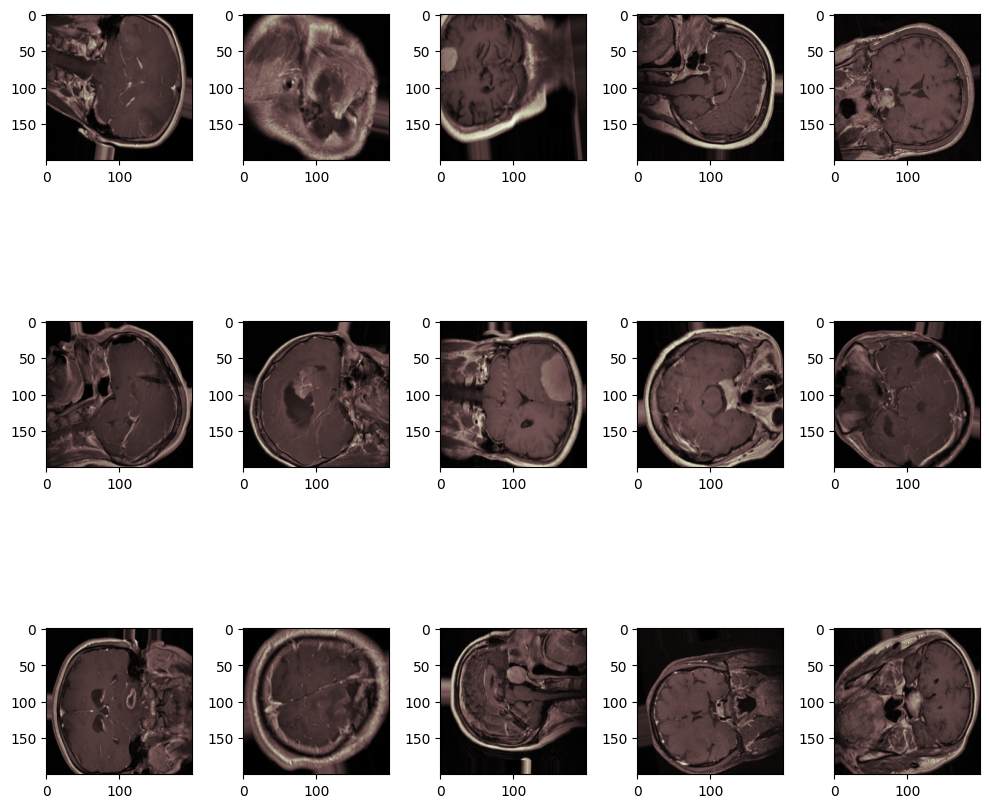

In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

## CSDA

In [11]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def PAB(inputs, channel_size):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    x = tf.reshape(x, [-1, 1, h*w])
    x = Activation('sigmoid')(x)
    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, channel_size]))
    x = tf.reshape(x, [-1, 1, 1, channel_size])
    
    return x

def CAB(inputs, reduction=8):
    shape = K.int_shape(inputs)

    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    
    return x
    
    
def CSDA(inputs,batch_size):

    f1 = []
    f2 = []
    half_size = inputs.shape[-1] // 2

    SPC_out = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=-1))(inputs)
    

    f1 = SPC_out[0]
    f2 = SPC_out[1]

    x = Concatenate()([CAB(f1), PAB(f1, half_size)])
    x = Conv2D(half_size, 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    f1 = Multiply()([x, f1])

    y = Concatenate()([CAB(f2), PAB(f2, half_size)])
    y = Conv2D(half_size, 1, padding='same')(y)
    y = Activation('sigmoid')(y)
    f2 = Multiply()([y, f2])

    outputs = Concatenate()([f1, f2])
        
    return outputs

def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = CSDA(x, 36)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5366 - accuracy: 0.7787
Epoch 1: val_accuracy improved from -inf to 0.36053, saving model to without.h5
Epoch 1: 15.25 seconds
264/264 [==============================] - 15s 52ms/step - loss: 0.5365 - accuracy: 0.7787 - val_loss: 2.3366 - val_accuracy: 0.3605 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8785
Epoch 2: val_accuracy improved from 0.36053 to 0.38899, saving model to without.h5
Epoch 2: 13.18 seconds
264/264 [==============================] - 13s 50ms/step - loss: 0.3072 - accuracy: 0.8785 - val_loss: 3.3224 - val_accuracy: 0.3890 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9268
Epoch 3: val_accuracy improved from 0.38899 to 0.93738, saving model to without.h5
Epoch 3: 13.17 seconds
264/264 [==============================] - 13s 50ms/step - loss: 0.1893 - accuracy: 0.9268 - val_

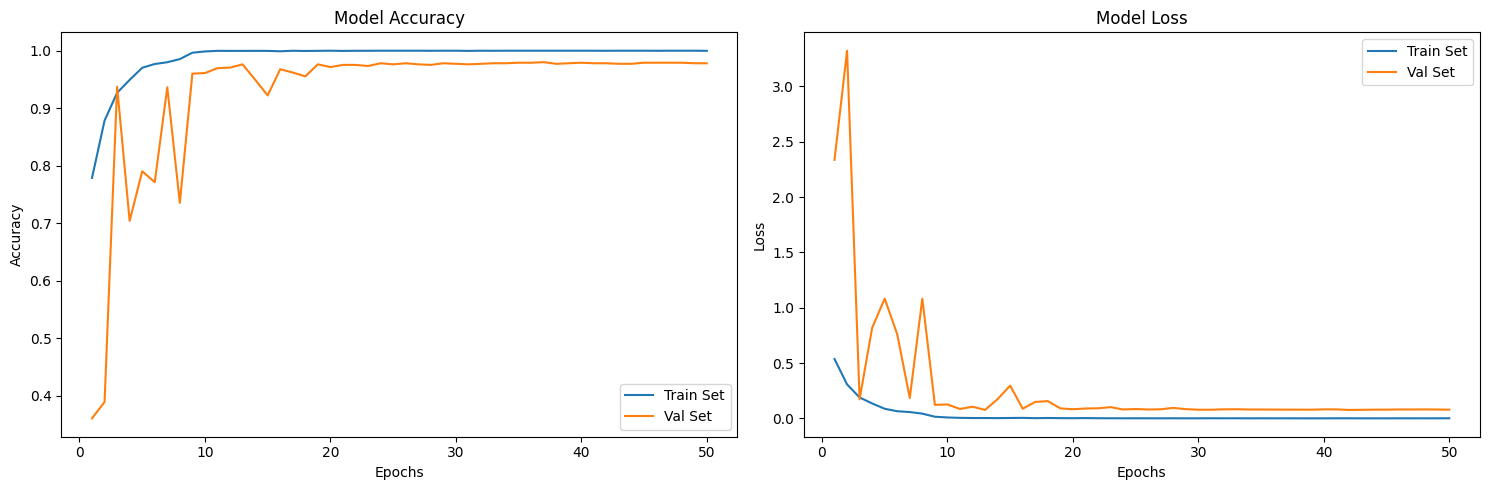

20/20 [==============================] - 0s 13ms/step - loss: 0.1014 - accuracy: 0.9691
Test Accuracy:  96.91
              precision    recall  f1-score   support

      glioma     0.9825    0.9790    0.9807       286
  meningioma     0.9371    0.9437    0.9404       142
   pituitary     0.9731    0.9731    0.9731       186

    accuracy                         0.9691       614
   macro avg     0.9642    0.9653    0.9647       614
weighted avg     0.9691    0.9691    0.9691       614



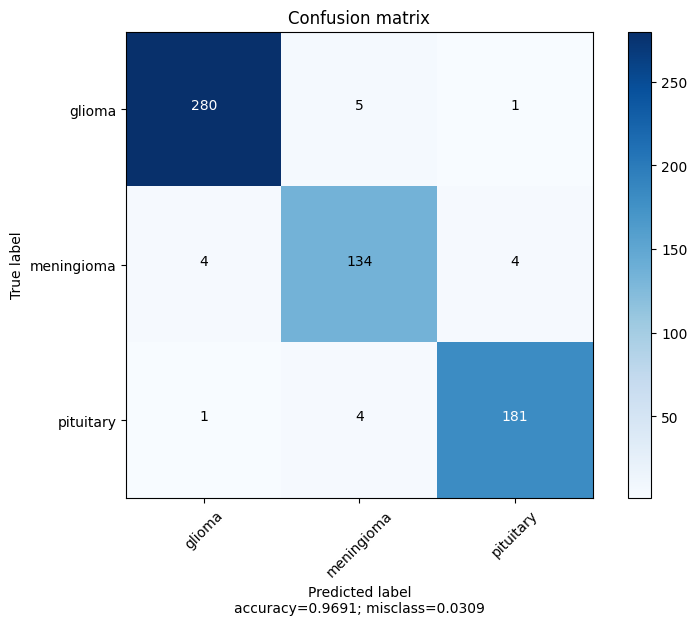

In [13]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
                              
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CSDA.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## Without Attention MOdule

In [14]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y



def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5164 - accuracy: 0.7824
Epoch 1: val_accuracy improved from -inf to 0.47533, saving model to CSDA.h5
Epoch 1: 16.05 seconds
264/264 [==============================] - 16s 54ms/step - loss: 0.5159 - accuracy: 0.7827 - val_loss: 1.0380 - val_accuracy: 0.4753 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8934
Epoch 2: val_accuracy improved from 0.47533 to 0.60626, saving model to CSDA.h5
Epoch 2: 13.46 seconds
264/264 [==============================] - 13s 51ms/step - loss: 0.2865 - accuracy: 0.8932 - val_loss: 1.9794 - val_accuracy: 0.6063 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2120 - accuracy: 0.9212
Epoch 3: val_accuracy improved from 0.60626 to 0.87381, saving model to CSDA.h5
Epoch 3: 13.60 seconds
264/264 [==============================] - 14s 52ms/step - loss: 0.2118 - accuracy: 0.9213 - val_loss: 0.3

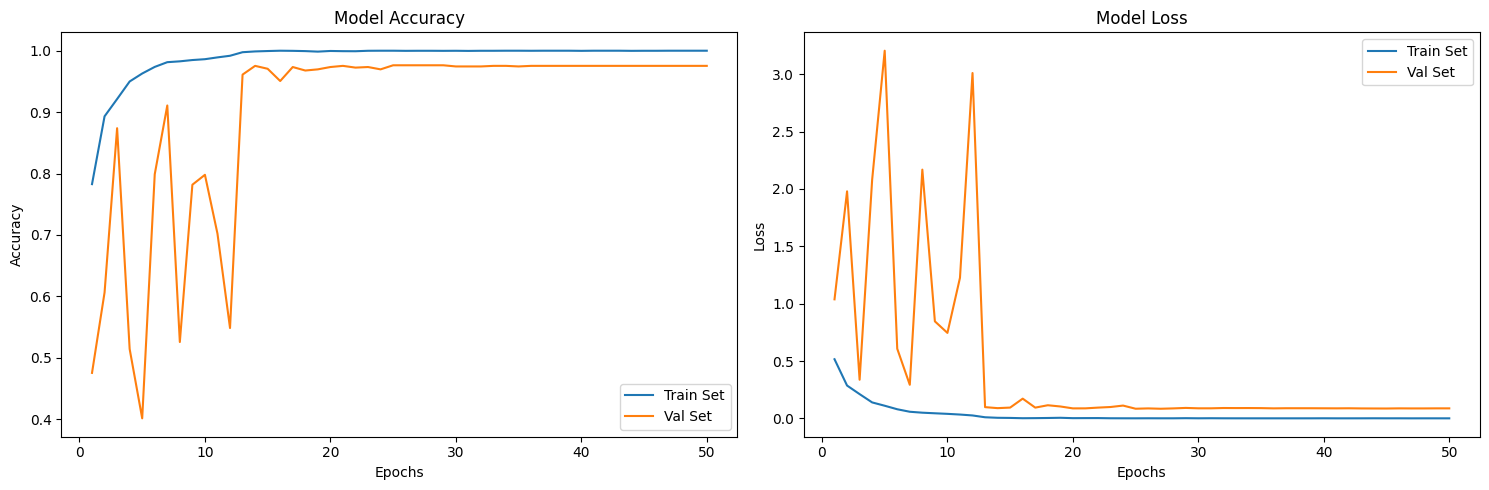

20/20 [==============================] - 0s 14ms/step - loss: 0.1335 - accuracy: 0.9625
Test Accuracy:  96.25
              precision    recall  f1-score   support

      glioma     0.9688    0.9755    0.9721       286
  meningioma     0.9172    0.9366    0.9268       142
   pituitary     0.9890    0.9624    0.9755       186

    accuracy                         0.9625       614
   macro avg     0.9583    0.9582    0.9581       614
weighted avg     0.9630    0.9625    0.9627       614



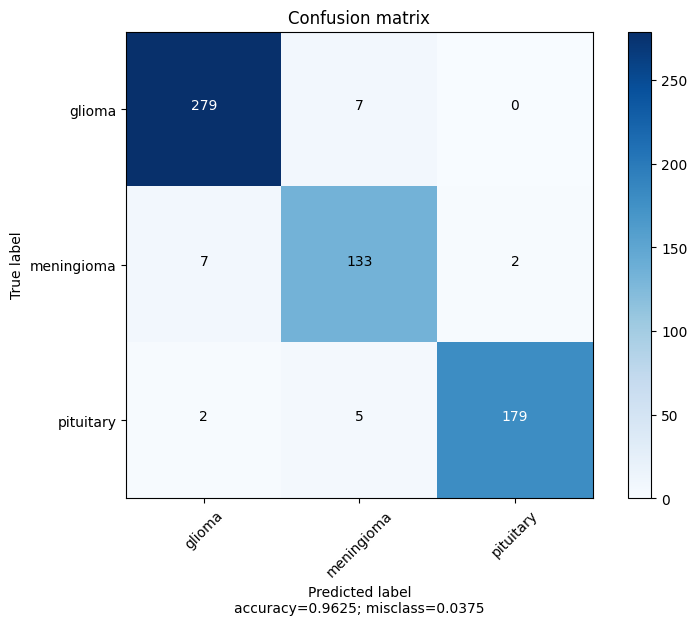

In [15]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='without.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## CBA

In [20]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def Spatial_attention_block(C_A, kernel_size=3):
    
    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(C_A)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(C_A)
    
    x = Concatenate()([x, y])
    x = Activation('relu')(x)
    x = Conv2D(1, kernel_size=kernel_size, padding='same')(x)
    x = Activation('sigmoid')(x)
    
    return x


def channel_attention(inputs, reduction=8):
    
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)

    se = tf.keras.Sequential([
            Conv2D(shape[3] // reduction, 1, padding='same'),
            Activation('relu'),
            Conv2D(shape[3], 1, padding='same')
        ])
        
    x = se(x)
    y = se(y)

    res = Add()([x, y])
    x = Activation('sigmoid')(res)

    return res

def CBA_block(inputs, reduction=8, kernel_size=3):

    x = channel_attention(inputs, reduction)
    x = Multiply()([x, inputs])
    y = Spatial_attention_block(x, kernel_size)
    y = Multiply()([y, x])

    return y

def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = CBA_block(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.5339 - accuracy: 0.7811
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to CBA.h5
Epoch 1: 15.62 seconds
264/264 [==============================] - 16s 53ms/step - loss: 0.5339 - accuracy: 0.7811 - val_loss: 66.6047 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8861
Epoch 2: val_accuracy improved from 0.33207 to 0.33966, saving model to CBA.h5
Epoch 2: 13.53 seconds
264/264 [==============================] - 14s 51ms/step - loss: 0.2976 - accuracy: 0.8863 - val_loss: 7.8151 - val_accuracy: 0.3397 - lr: 0.0010
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9174
Epoch 3: val_accuracy improved from 0.33966 to 0.77135, saving model to CBA.h5
Epoch 3: 13.56 seconds
264/264 [==============================] - 14s 51ms/step - loss: 0.2119 - accuracy: 0.9174 - val_loss: 1.1431 - val_

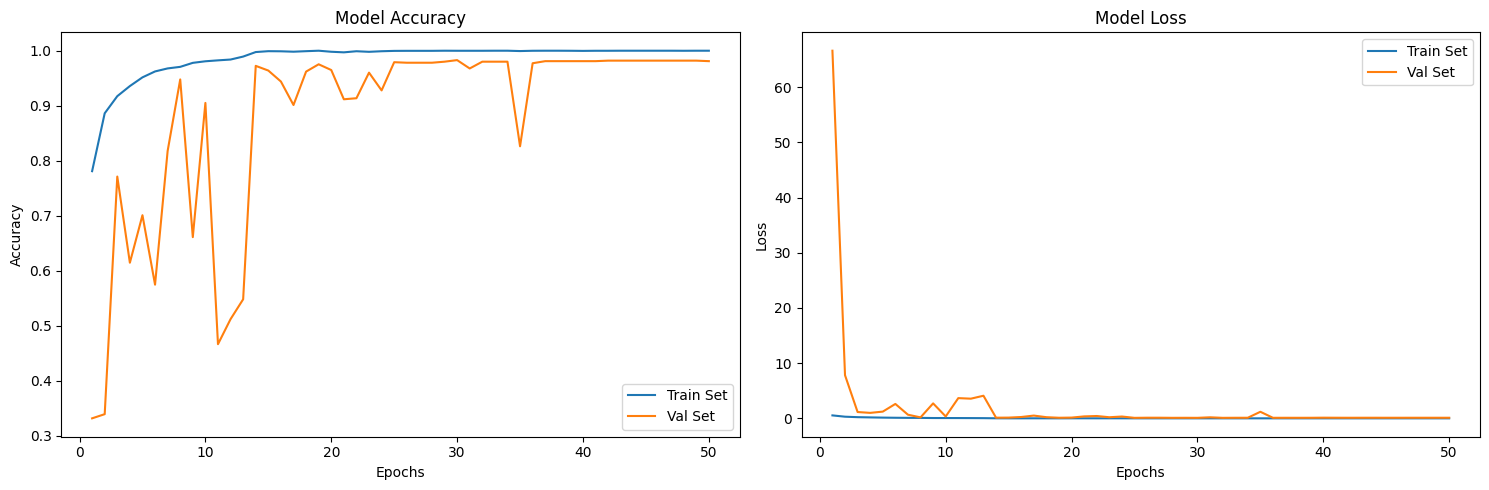

20/20 [==============================] - 0s 14ms/step - loss: 0.1449 - accuracy: 0.9674
Test Accuracy:  96.74
              precision    recall  f1-score   support

      glioma     0.9823    0.9685    0.9754       286
  meningioma     0.9565    0.9296    0.9429       142
   pituitary     0.9536    0.9946    0.9737       186

    accuracy                         0.9674       614
   macro avg     0.9641    0.9642    0.9640       614
weighted avg     0.9676    0.9674    0.9673       614



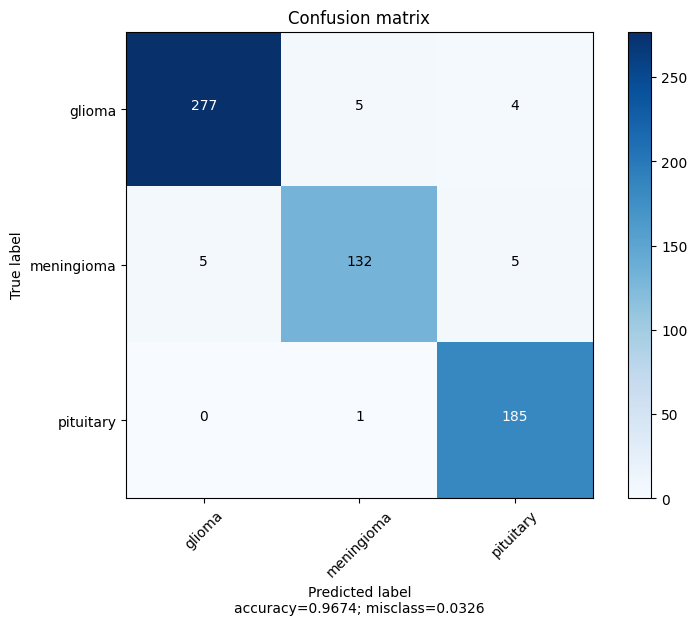

In [25]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CBA.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)


## LGA

In [26]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def Spatial_attention_block(C_A):
    
    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(C_A)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(C_A)
    
    x = Concatenate()([x, y])
    x = Activation('relu')(x)
    x = Conv2D(1, 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    S_A = Multiply()([x, C_A])
    
    return S_A

def self_attention(inp, reduction=8):
    shp = inp.shape
    a = Conv2D(shp[3] // reduction, 1, padding='same')(inp)
    a = Activation('relu')(a)
    
    b = Conv2D(shp[3] // reduction, 1, padding='same')(inp)
    b = Activation('relu')(b)
    
    c = Conv2D(shp[3] // reduction, 1, padding='same')(inp)
    c = Activation('relu')(c)
    
    a = Reshape((shp[1] * shp[2], shp[3] // reduction))(a)
    
    b = Reshape((shp[1] * shp[2], shp[3] // reduction))(b)
    b = K.permute_dimensions(b, (0, 2, 1))
    c = Reshape((shp[1] * shp[2], shp[3] // reduction))(c)
    inter = K.batch_dot(a, b)
    inter = Activation('softmax')(inter)
    out = K.batch_dot(inter, c)
    out = Reshape((shp[1], shp[2], shp[3] // reduction))(out)
    out = Conv2D(shp[3], 1, padding='same')(out)
    out = Activation('relu')(out)
    
    return out

def channel_attention(inputs, reduction=8):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def LGA_block(inputs):

    a31 = self_attention(inputs)
    a32 = Spatial_attention_block(inputs)
    a3 = Add()([a31, a32])
    x = channel_attention(a3)

    return x

def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = LGA_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5763 - accuracy: 0.7574
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to LGA.h5
Epoch 1: 16.54 seconds
264/264 [==============================] - 17s 55ms/step - loss: 0.5759 - accuracy: 0.7576 - val_loss: 27.3377 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3251 - accuracy: 0.8700
Epoch 2: val_accuracy did not improve from 0.33207
Epoch 2: 13.53 seconds
264/264 [==============================] - 14s 51ms/step - loss: 0.3251 - accuracy: 0.8700 - val_loss: 30.6805 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.9016
Epoch 3: val_accuracy improved from 0.33207 to 0.55028, saving model to LGA.h5
Epoch 3: 13.86 seconds
264/264 [==============================] - 14s 53ms/step - loss: 0.2558 - accuracy: 0.9016 - val_loss: 3.4757 - val_accuracy: 0.5503 - lr: 0.00

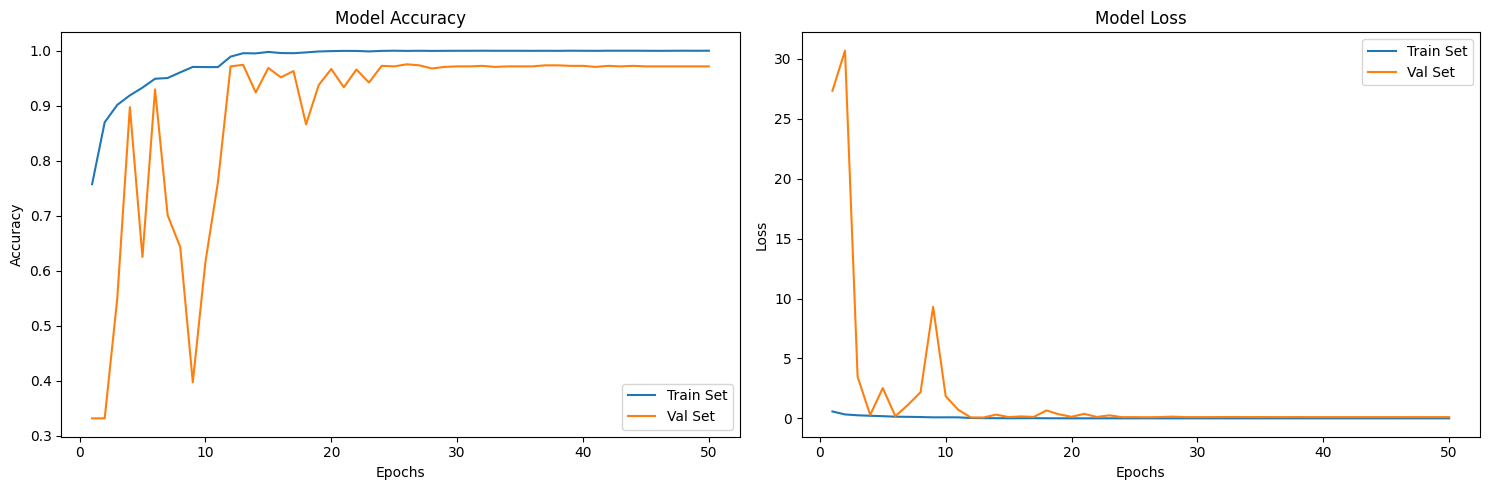

20/20 [==============================] - 0s 14ms/step - loss: 0.1350 - accuracy: 0.9707
Test Accuracy:  97.07
              precision    recall  f1-score   support

      glioma     0.9859    0.9755    0.9807       286
  meningioma     0.9375    0.9507    0.9441       142
   pituitary     0.9733    0.9785    0.9759       186

    accuracy                         0.9707       614
   macro avg     0.9655    0.9682    0.9669       614
weighted avg     0.9709    0.9707    0.9707       614



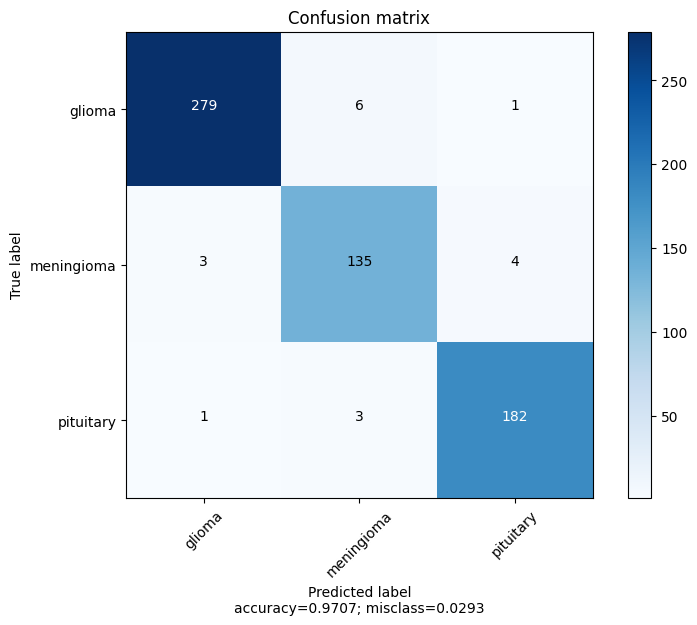

In [27]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='LGA.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)


## SEA

In [31]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def SEA_block(inputs, channel=512, reduction=4):
    
    b, h, w, c = inputs.shape.as_list()

    SE_out = tf.keras.layers.AveragePooling2D(pool_size=(w, h))(inputs)
    SE_out = tf.reshape(SE_out, [-1,c])
    
    SE_out = tf.keras.Sequential([
            Dense(units=c // reduction, use_bias=False),
            ReLU(),
            Dense(units=c, use_bias=False),
            Activation('sigmoid')
        ])(SE_out)
    
    SE_out = tf.reshape(SE_out, [-1,1,1,c])
    PSA_out = tf.multiply(inputs, SE_out)
    
    return PSA_out

def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = SEA_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5789 - accuracy: 0.7583
Epoch 1: val_accuracy improved from -inf to 0.50095, saving model to LGA.h5
Epoch 1: 15.36 seconds
264/264 [==============================] - 15s 52ms/step - loss: 0.5788 - accuracy: 0.7585 - val_loss: 1.0491 - val_accuracy: 0.5009 - lr: 0.0010
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3626 - accuracy: 0.8573
Epoch 2: val_accuracy did not improve from 0.50095
Epoch 2: 13.00 seconds
264/264 [==============================] - 13s 49ms/step - loss: 0.3628 - accuracy: 0.8574 - val_loss: 6.7095 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.8893
Epoch 3: val_accuracy did not improve from 0.50095
Epoch 3: 13.00 seconds
264/264 [==============================] - 13s 49ms/step - loss: 0.2901 - accuracy: 0.8893 - val_loss: 15.7566 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 4/50
263/264 [======

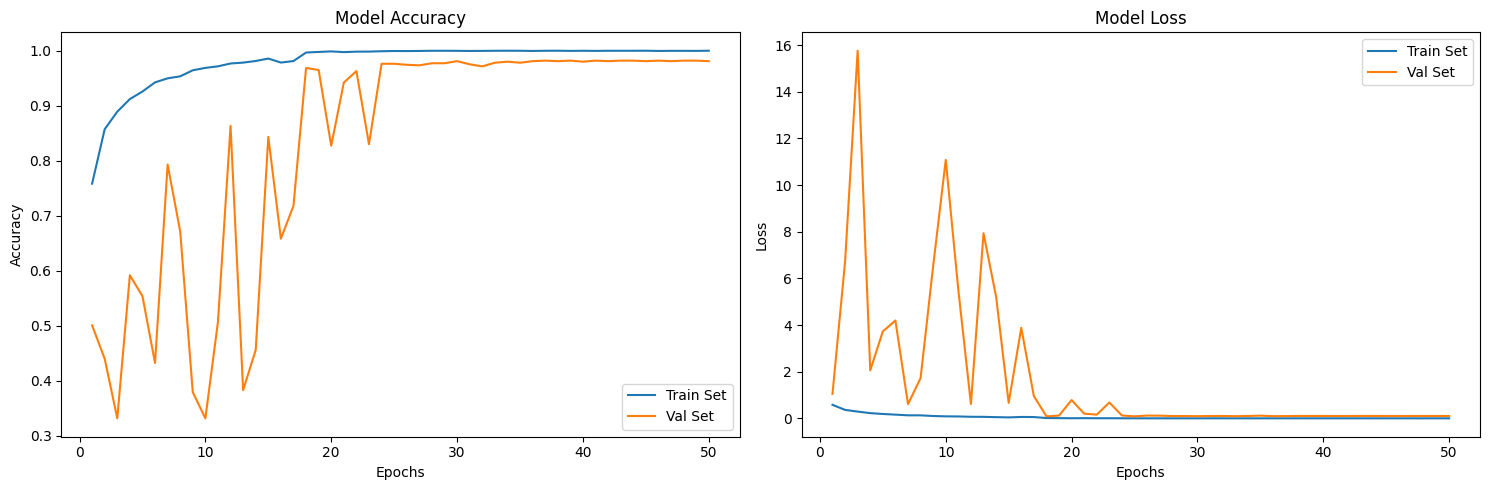

20/20 [==============================] - 0s 13ms/step - loss: 0.1191 - accuracy: 0.9707
Test Accuracy:  97.07
              precision    recall  f1-score   support

      glioma     0.9759    0.9895    0.9826       286
  meningioma     0.9493    0.9225    0.9357       142
   pituitary     0.9785    0.9785    0.9785       186

    accuracy                         0.9707       614
   macro avg     0.9679    0.9635    0.9656       614
weighted avg     0.9705    0.9707    0.9705       614



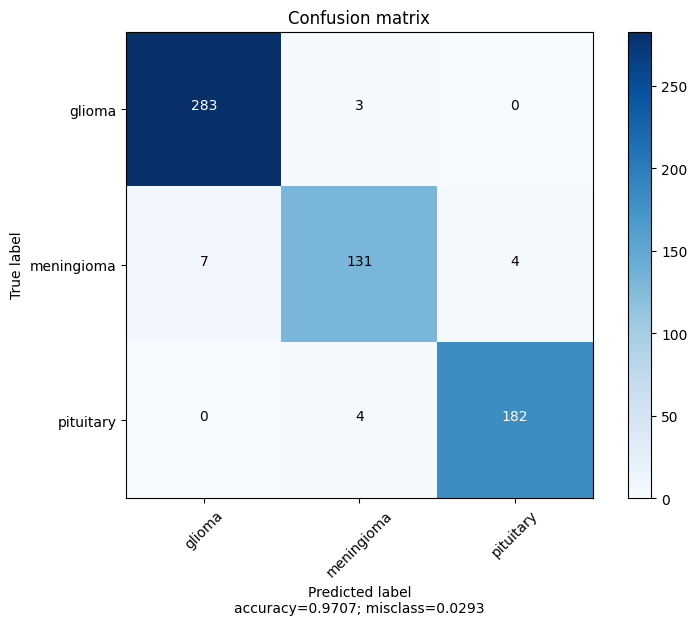

In [33]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='SEA.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## PSA

In [34]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def PSA_block(inputs, channel=512, reduction=4, S=4, ):
    
    b, h, w, c = inputs.shape.as_list()

    SPC_out = Lambda(lambda x: tf.split(x, num_or_size_splits=S, axis=-1))(inputs)
    SPC_out = tf.stack(SPC_out, axis=3)

    SPC_ = []
    for i in range(S):
        x = Conv2D(c//S, kernel_size=2*(i+1)+1, padding='same')(SPC_out[:, :, :, i, :])
        SPC_.append(x)
    SPC_out = tf.stack(SPC_, axis=3)


    se_blocks = []
    se_out_=[]
    for i in range(S):
        input_tensor = SPC_out[:, :, :, i, :]
        se_blocks.append(tf.keras.Sequential([
            tf.keras.layers.AveragePooling2D(pool_size=(w, h)),
            Conv2D(c // (S*reduction), kernel_size=1, use_bias=False),
            ReLU(),
            Conv2D(c // S, kernel_size=1, use_bias=False),
            Activation('sigmoid')
        ]))

        se_out_.append(se_blocks[i](input_tensor))
    SE_out = tf.stack(se_out_, axis=3)


    softmax_out = tf.nn.softmax(SE_out, axis=3)


    PSA_out = tf.multiply(SPC_out, softmax_out)
    PSA_out = Concatenate()([PSA_out[:,:,:,0,:], PSA_out[:,:,:,1,:], PSA_out[:,:,:,2,:], PSA_out[:,:,:,3,:]])

    return PSA_out


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = PSA_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.7250 - accuracy: 0.6993
Epoch 1: val_accuracy improved from -inf to 0.42505, saving model to LGA.h5
Epoch 1: 17.45 seconds
264/264 [==============================] - 17s 57ms/step - loss: 0.7247 - accuracy: 0.6995 - val_loss: 1.1305 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.4464 - accuracy: 0.8214
Epoch 2: val_accuracy improved from 0.42505 to 0.49336, saving model to LGA.h5
Epoch 2: 14.24 seconds
264/264 [==============================] - 14s 54ms/step - loss: 0.4462 - accuracy: 0.8213 - val_loss: 1.5033 - val_accuracy: 0.4934 - lr: 0.0010
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8698
Epoch 3: val_accuracy did not improve from 0.49336
Epoch 3: 14.21 seconds
264/264 [==============================] - 14s 54ms/step - loss: 0.3411 - accuracy: 0.8697 - val_loss: 3.4194 - val_accuracy: 0.3321 - lr: 0.0010

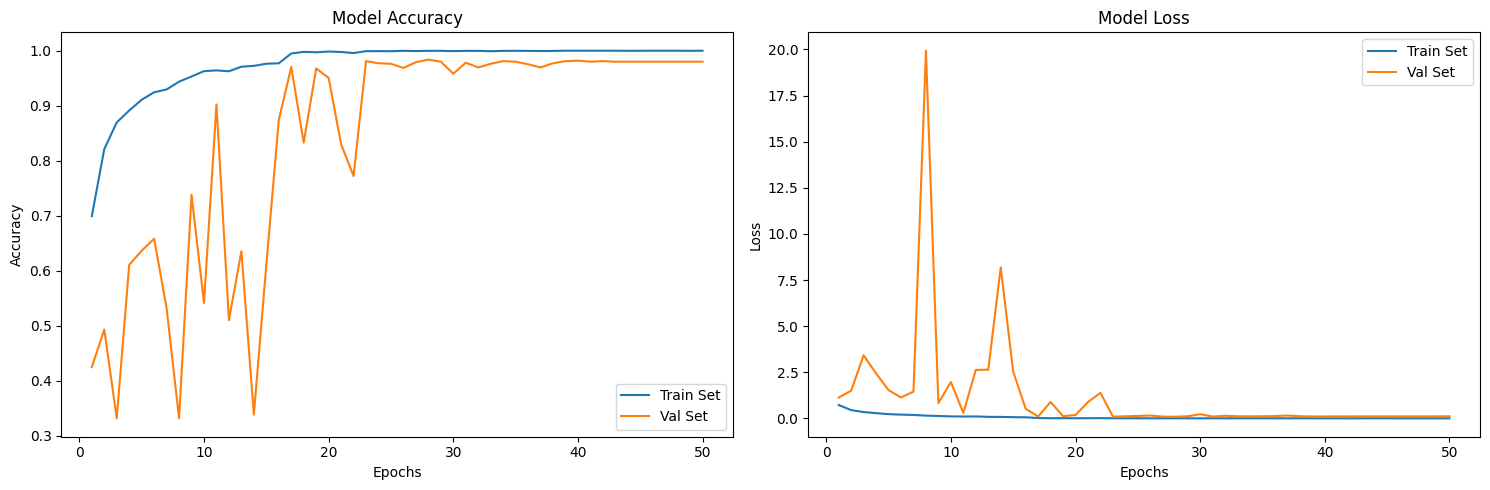

20/20 [==============================] - 0s 15ms/step - loss: 0.1395 - accuracy: 0.9658
Test Accuracy:  96.58
              precision    recall  f1-score   support

      glioma     0.9689    0.9790    0.9739       286
  meningioma     0.9424    0.9225    0.9324       142
   pituitary     0.9785    0.9785    0.9785       186

    accuracy                         0.9658       614
   macro avg     0.9633    0.9600    0.9616       614
weighted avg     0.9657    0.9658    0.9657       614



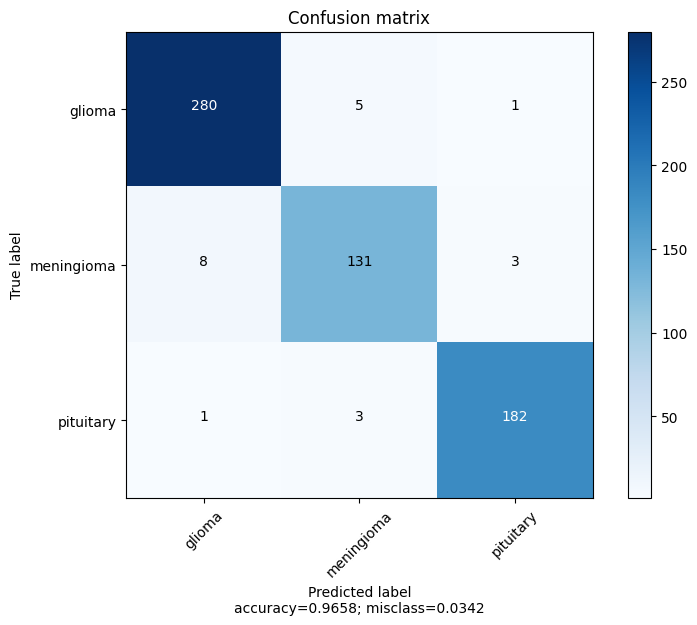

In [35]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='PSA.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## iPPM

In [3]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def iPPM(inputs):

    a = UpSampling2D(size=(6, 6))(inputs)
    a = MaxPooling2D(pool_size=(6, 6))(a)
    a = Conv2D(128, 1, padding='same')(a)

    b = UpSampling2D(size=(4, 4))(inputs)
    b = MaxPooling2D(pool_size=(4, 4))(b)
    b = Conv2D(128, 1, padding='same')(b)

    c = UpSampling2D(size=(3, 3))(inputs)
    c = MaxPooling2D(pool_size=(3, 3))(c)
    c = Conv2D(128, 1, padding='same')(c)

    d = UpSampling2D(size=(2, 2))(inputs)
    d = MaxPooling2D(pool_size=(2, 2))(d)
    d = Conv2D(128, 1, padding='same')(d)

    x =  Concatenate()([a, b, c, d])
    x = Conv2D(256, 1, padding='same')(x)
    x = Conv2D(128, 1, padding='same')(x)

    return x


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = iPPM(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

2024-03-16 20:35:45.341568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 20:35:45.644015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c2:00.0, compute capability: 8.9


Epoch 1/50


2024-03-16 20:35:54.239380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-16 20:35:55.157402: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-16 20:35:55.157436: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-16 20:35:55.157580: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-16 20:35:55.805810: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.6999
Epoch 1: val_accuracy improved from -inf to 0.41271, saving model to LGA.h5
Epoch 1: 22.62 seconds
264/264 [==============================] - 23s 65ms/step - loss: 0.7893 - accuracy: 0.6999 - val_loss: 6.0262 - val_accuracy: 0.4127 - lr: 0.0010
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.4756 - accuracy: 0.8172
Epoch 2: val_accuracy improved from 0.41271 to 0.46964, saving model to LGA.h5
Epoch 2: 15.69 seconds
264/264 [==============================] - 16s 59ms/step - loss: 0.4762 - accuracy: 0.8169 - val_loss: 2.0990 - val_accuracy: 0.4696 - lr: 0.0010
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.3960 - accuracy: 0.8485
Epoch 3: val_accuracy improved from 0.46964 to 0.82732, saving model to LGA.h5
Epoch 3: 15.67 seconds
264/264 [==============================] - 16s 59ms/step - loss: 0.3963 - accuracy: 0.8485 - val_loss: 0.4437 - val_accuracy: 0.

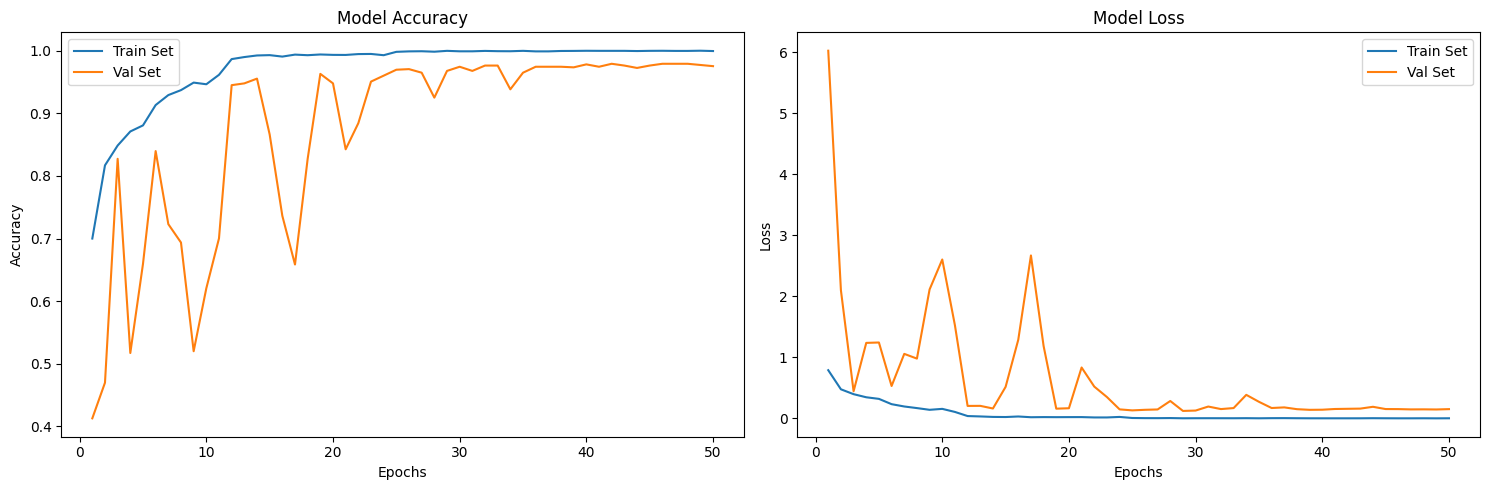

20/20 [==============================] - 0s 17ms/step - loss: 0.2159 - accuracy: 0.9642
Test Accuracy:  96.42
              precision    recall  f1-score   support

      glioma     0.9691    0.9860    0.9775       286
  meningioma     0.9485    0.9085    0.9281       142
   pituitary     0.9679    0.9731    0.9705       186

    accuracy                         0.9642       614
   macro avg     0.9618    0.9559    0.9587       614
weighted avg     0.9640    0.9642    0.9639       614



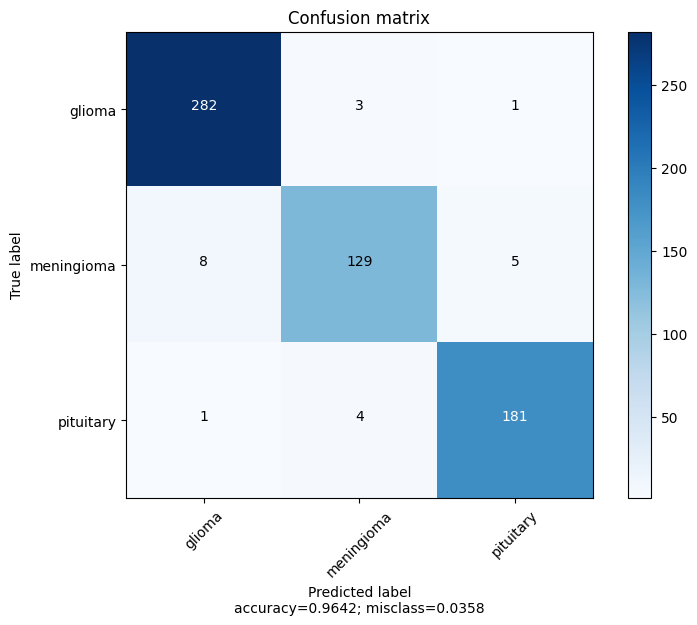

In [4]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='iPPM.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)